In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import sklearn

Load necessary datasets

In [2]:
#load mutations table for RNAP
mutations = pd.read_csv('data/RNAP_MUTATIONS.csv')
mutations

,UNIQUEID,GENE,MUTATION,REF,ALT,NUCLEOTIDE_NUMBER,NUCLEOTIDE_INDEX,GENE_POSITION,CODES_PROTEIN,INDEL_LENGTH,INDEL_NUCLEOTIDES,AMINO_ACID_NUMBER,AMINO_ACID_SEQUENCE,NUMBER_NUCLEOTIDE_CHANGES,IS_MINOR_ALLELE,MINOR_MUTATION,FRS
0,site.01.subj.DR0682.lab.DR0682.iso.1,rpoB,S450L,tcg,ttg,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,False,NaN,NaN
1,site.01.subj.DR0682.lab.DR0682.iso.1,rpoB,A1075A,gct,gcc,NaN,NaN,1075.0,True,NaN,NaN,1075.0,A,1.0,False,NaN,NaN
2,site.01.subj.DR0674.lab.DR0674.iso.1,rpoB,S450L,tcg,ttg,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,False,NaN,NaN
3,site.01.subj.DR0674.lab.DR0674.iso.1,rpoB,E561E,gag,gaa,NaN,NaN,561.0,True,NaN,NaN,561.0,E,1.0,False,NaN,NaN
4,site.01.subj.DR0134.lab.DR0134.iso.1,rpoB,S450L,tcg,ttg,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176550,site.07.subj.718655D6-1333-4F67-AABF-09C7E521D...,rpoB,1326_del_gttgaccca,NaN,NaN,1326.0,761132.0,1326.0,True,-9.0,gttgaccca,NaN,NaN,NaN,False,NaN,NaN
176551,site.07.subj.718655D6-1333-4F67-AABF-09C7E521D...,rpoC,A172V,gcc,gtc,NaN,NaN,172.0,True,NaN,NaN,172.0,V,1.0,False,NaN,NaN
176552,site.07.subj.718655D6-1333-4F67-AABF-09C7E521D...,rpoC,R173R,cgg,agg,NaN,NaN,173.0,True,NaN,NaN,173.0,R,1.0,False,NaN,NaN
176553,site.07.subj.718655D6-1333-4F67-AABF-09C7E521D...,rpoC,P601L,ccg,ctg,NaN,NaN,601.0,True,NaN,NaN,601.0,L,1.0,False,NaN,NaN


In [3]:
#load known resistance mutations from EFFECTS table
effects = pd.read_pickle('data/EFFECTS.pkl.gz')
effects.reset_index(inplace = True)
effects['GENE_MUTATION'] = effects['GENE'].astype(str) + '_' + effects['MUTATION']
effects = effects[(effects.DRUG=='RIF') & (effects.PREDICTION=='R') 
                  & (~effects.MUTATION.str[-1].isin(['O','X']))]

resistance_mutations = effects.GENE_MUTATION.unique()
len(resistance_mutations)

128

In [4]:
#load conservative list of CMs from previous paper
CMs = pd.read_csv('data/final_CM_hit_list.csv')
CMs = CMs[CMs.homoplasy == True]
CMs

compensatory_mutations = CMs['putative CM'].unique()
len(compensatory_mutations)

51

In [5]:
#add resistance and compensatory mutation flags to mutations table: need to check for minor allele before concatenating GENE_MUTATION 
# use resistance catalogue of WHO instead?
mutations['GENE_MUTATION'] = np.where(
    mutations['IS_MINOR_ALLELE'],  # Condition: if IS_MINOR_ALLELE is True
    mutations['GENE'].astype(str) + '_' + mutations['MINOR_MUTATION'].astype(str),  # Then: use GENE + MINOR_MUTATION
    mutations['GENE'].astype(str) + '_' + mutations['MUTATION'].astype(str)  # Else: use GENE + MUTATION
)
    
mutations['RESISTANT_MUTATION'] = mutations['GENE_MUTATION'].isin(resistance_mutations)
mutations['COMPENSATORY_MUTATION'] = mutations['GENE_MUTATION'].isin(compensatory_mutations)

mutations

,UNIQUEID,GENE,MUTATION,REF,ALT,NUCLEOTIDE_NUMBER,NUCLEOTIDE_INDEX,GENE_POSITION,CODES_PROTEIN,INDEL_LENGTH,INDEL_NUCLEOTIDES,AMINO_ACID_NUMBER,AMINO_ACID_SEQUENCE,NUMBER_NUCLEOTIDE_CHANGES,IS_MINOR_ALLELE,MINOR_MUTATION,FRS,GENE_MUTATION,RESISTANT_MUTATION,COMPENSATORY_MUTATION
0,site.01.subj.DR0682.lab.DR0682.iso.1,rpoB,S450L,tcg,ttg,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,False,NaN,NaN,rpoB_S450L,True,False
1,site.01.subj.DR0682.lab.DR0682.iso.1,rpoB,A1075A,gct,gcc,NaN,NaN,1075.0,True,NaN,NaN,1075.0,A,1.0,False,NaN,NaN,rpoB_A1075A,False,False
2,site.01.subj.DR0674.lab.DR0674.iso.1,rpoB,S450L,tcg,ttg,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,False,NaN,NaN,rpoB_S450L,True,False
3,site.01.subj.DR0674.lab.DR0674.iso.1,rpoB,E561E,gag,gaa,NaN,NaN,561.0,True,NaN,NaN,561.0,E,1.0,False,NaN,NaN,rpoB_E561E,False,False
4,site.01.subj.DR0134.lab.DR0134.iso.1,rpoB,S450L,tcg,ttg,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,False,NaN,NaN,rpoB_S450L,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176550,site.07.subj.718655D6-1333-4F67-AABF-09C7E521D...,rpoB,1326_del_gttgaccca,NaN,NaN,1326.0,761132.0,1326.0,True,-9.0,gttgaccca,NaN,NaN,NaN,False,NaN,NaN,rpoB_1326_del_gttgaccca,True,False
176551,site.07.subj.718655D6-1333-4F67-AABF-09C7E521D...,rpoC,A172V,gcc,gtc,NaN,NaN,172.0,True,NaN,NaN,172.0,V,1.0,False,NaN,NaN,rpoC_A172V,False,False
176552,site.07.subj.718655D6-1333-4F67-AABF-09C7E521D...,rpoC,R173R,cgg,agg,NaN,NaN,173.0,True,NaN,NaN,173.0,R,1.0,False,NaN,NaN,rpoC_R173R,False,False
176553,site.07.subj.718655D6-1333-4F67-AABF-09C7E521D...,rpoC,P601L,ccg,ctg,NaN,NaN,601.0,True,NaN,NaN,601.0,L,1.0,False,NaN,NaN,rpoC_P601L,False,False


In [6]:
#add phenotypes flag to mutations table (filter out low quality phenotypes)
phenotypes = pd.read_pickle('data/DST_MEASUREMENTS.pkl.gz')
phenotypes.reset_index(inplace = True)
phenotypes = phenotypes[(phenotypes.DRUG == 'RIF')] #  & (phenotypes.QUALITY != 'LOW')
phenotypes

#merge mutations and phenotypes tables, can also do a left join to keep samples without phenotypes (might be useful for CM statistics)
mutations_phenotypes = pd.merge(mutations, phenotypes[['UNIQUEID','PHENOTYPE','QUALITY']], on = 'UNIQUEID', how = 'inner')
mutations_phenotypes['PHENOTYPE'] = mutations_phenotypes['PHENOTYPE'] == 'R'

#drop UNIQUEIDs with phenotypes of low quality
low_quality_ids = mutations_phenotypes[mutations_phenotypes['QUALITY'] == 'LOW']['UNIQUEID'].unique()
mutations_phenotypes = mutations_phenotypes[~mutations_phenotypes['UNIQUEID'].isin(low_quality_ids)]

mutations_phenotypes = mutations_phenotypes.drop(columns = ['QUALITY'])
print(len(mutations_phenotypes.UNIQUEID.unique()))

28052


Calculate sensitivity and specificity of RIF resistance in all samples using different FRS scores

In [7]:
# aggregate mutations_phenotype by UNIQUEID and keep columns of interest: included new definition of FRS
def aggregate_minor_major_allele(group):
    # Check if any row has both IS_MINOR_ALLELE == True and RESISTANT_MUTATION == True
    minor_allele_flag = any((group['IS_MINOR_ALLELE'] == True) & (group['RESISTANT_MUTATION'] == True))
    major_allele_flag = any((group['IS_MINOR_ALLELE'] == False) & (group['RESISTANT_MUTATION'] == True))

    # Get the rows where there is a resistant minor allele
    resistant_minor_allele_rows = group[(group['IS_MINOR_ALLELE'] == True) & (group['RESISTANT_MUTATION'] == True)]
    
    if not resistant_minor_allele_rows.empty:
        # If there are resistant minor alleles, get the maximum FRS value for those rows
        frs_value = resistant_minor_allele_rows['FRS'].max()
    else:
        # Otherwise, use the maximum FRS value from the entire group
        frs_value = group['FRS'].max()
    
    return pd.Series({
        'RESISTANT_MUTATION': group['RESISTANT_MUTATION'].max(),
        'COMPENSATORY_MUTATION': group['COMPENSATORY_MUTATION'].max(),
        'PHENOTYPE': group['PHENOTYPE'].max(),
        'R_MINOR_ALLELE': minor_allele_flag,
        'R_MAJOR_ALLELE': major_allele_flag,
        'FRS': frs_value,  # Use the maximum FRS for resistant minor alleles, if present
    })

# Apply the custom aggregation function
mutations_agg_phen = mutations_phenotypes.groupby('UNIQUEID').apply(aggregate_minor_major_allele).reset_index()

/var/folders/_3/8y_dwngx2614_y_52fzh1c4w0000gn/T/ipykernel_36975/2414199851.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mutations_agg = mutations_phenotypes.groupby('UNIQUEID').apply(aggregate_minor_major_allele).reset_index()


In [8]:
# define function for calculating sensitivity, specificity, PPV and NPV
#calculate sensitivity: number of phenotypically resistant samples that are found to have a resistant mutation / total number of phenotypically resistant samples
#calculate specificity: number of phenotypically sensitive samples that do not have a resistance mutation / total number of phenotypically sensitive samples
#calculate PPV: number of samples with a resistance mutation that are phenotypically resistant / total number of samples with a resistance mutation
#calculate NPV: number of samples without a resistance mutation that are phenotypically sensitive / total number of samples without a resistance mutation

def calculate_statistics(df):
    sensitivity = df[(df['PHENOTYPE'] == True) & (df['RESISTANT_MUTATION'] == True)].shape[0] / df[df['PHENOTYPE'] == True].shape[0]
    specificity = df[(df['PHENOTYPE'] == False) & (df['RESISTANT_MUTATION'] == False)].shape[0] / df[df['PHENOTYPE'] == False].shape[0]
    PPV = df[(df['RESISTANT_MUTATION'] == True) & (df['PHENOTYPE'] == True)].shape[0] / df[df['RESISTANT_MUTATION'] == True].shape[0]
    NPV = df[(df['RESISTANT_MUTATION'] == False) & (df['PHENOTYPE'] == False)].shape[0] / df[df['RESISTANT_MUTATION'] == False].shape[0]
    return sensitivity, specificity, PPV, NPV

In [9]:
#calculate statistics for no FRS cutoff
print(mutations_agg_phen.RESISTANT_MUTATION.value_counts())
sen_all, spe_all, ppv_all, npv_all = calculate_statistics(mutations_agg_phen)
sen_all, spe_all, ppv_all, npv_all

RESISTANT_MUTATION
False    17302
True     10750
Name: count, dtype: int64


(0.971577223239233, 0.96231539636734, 0.938046511627907, 0.9829499479828921)

In [10]:
#calculate statistics for FRS cutoff >=0.9 (major allele definition)
major_mutations = mutations_agg_phen.copy()
major_mutations['RESISTANT_MUTATION'] = major_mutations['R_MAJOR_ALLELE']
print(major_mutations.RESISTANT_MUTATION.value_counts())
sen_maj, spe_maj, ppv_maj, npv_maj = calculate_statistics(major_mutations)
sen_maj, spe_maj, ppv_maj, npv_maj

RESISTANT_MUTATION
False    17566
True     10486
Name: count, dtype: int64


(0.9501878793718085, 0.964691902902733, 0.940492084684341, 0.9705681430035296)

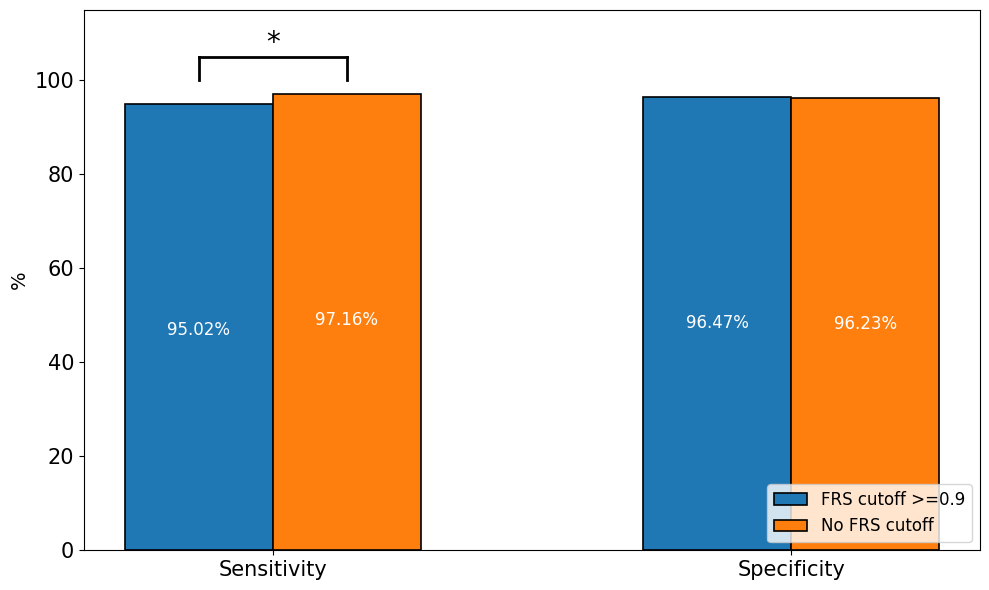

In [11]:
# plot sensitivity and specificity for no FRS cutoff and for FRS cutoff >=0.9 (major allele definition) as a histogram
def create_stats_df(sen_1, sen_2, spe_1, spe_2):
    stats = pd.DataFrame({
        'Metric': ['Sensitivity', 'Specificity'],
        'FRS cutoff >=0.9 (major allele definition)': [sen_1, spe_1],
        'No FRS cutoff': [sen_2, spe_2]
    })
    return stats


def plot_stats_histogram(stats, significant = True, save_figure=False, save_name='sensitivity_specificity_histogram', legend_label_1 = 'FRS cutoff >=0.9', legen_label_2 = 'No FRS cutoff'):
    # Adjusting the plot to group bars by criteria and display percentage inside the bar
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plotting bars next to each other
    x = [0, 0.7]  # positions for FRS cutoff >=0.9 (major allele definition)
    bar_width = 0.2

    bars1 = ax.bar(x, stats['FRS cutoff >=0.9 (major allele definition)'], 
                width=bar_width, color='#1f77b4', edgecolor='black', linewidth=1.2, label=legend_label_1)
    bars2 = ax.bar([p + bar_width for p in x], stats['No FRS cutoff'], 
                width=bar_width, color='#ff7f0e', edgecolor='black', linewidth=1.2, label=legen_label_2)

    # Adding percentage values inside the bars
    for bars in [bars1, bars2]:
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval - 0.5, f'{yval:.2%}', 
                    ha='center', va='bottom', fontsize=12, color='white')

    # Customize the plot
    # Set y-axis to display values as percentages without the percent sign
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}'.format(y * 100)))

    # ax.set_title('Sensitivity and Specificity for Rifampicin Resistance', fontsize=18)
    ax.set_ylabel('%', fontsize=14)
    ax.set_ylim(0, 1.15)

    # Setting custom x-axis labels
    ax.set_xticks([r + bar_width/2 for r in x])
    ax.set_xticklabels(['Sensitivity', 'Specificity'], fontsize=15)

    # Increase axis fontsizes
    ax.tick_params(axis='both', which='major', labelsize=15)

    # Adding the legend
    ax.legend(loc='lower right', fontsize=12)

    #add significance indicator with horizontal bar between bars of sensitivity
    if significant:
        ax.plot([0, 0], [1, 1.05], color='black', lw=2)
        ax.plot([0.2, 0.2], [1, 1.05], color='black', lw=2)
        ax.plot([0, 0.2], [1.05, 1.05], color='black', lw=2)
        ax.text(0.1, 1.08, '*', fontsize=20, color='black', ha='center', va='center')

    plt.tight_layout()
    plt.show()

    #save figure if print_stats is True
    if save_figure:
        fig.savefig(f'figures/{save_name}.png', dpi=300)


stats = create_stats_df(sen_maj, sen_all, spe_maj, spe_all)
plot_stats_histogram(stats, significant = True, save_figure=True, save_name = 'sensitivity_specificity_histogram')

In [12]:
#perform a z test to test for significant difference between the sensitivities and specificities
from statsmodels.stats.proportion import proportions_ztest

# Sensitivity
count = np.array([mutations_agg_phen[(mutations_agg['PHENOTYPE'] == True) & (mutations_agg_phen['RESISTANT_MUTATION'] == True)].shape[0], major_mutations[(major_mutations['PHENOTYPE'] == True) & (major_mutations['RESISTANT_MUTATION'] == True)].shape[0]])
nobs = np.array([mutations_agg_phen[mutations_agg_phen['PHENOTYPE'] == True].shape[0], major_mutations[major_mutations['PHENOTYPE'] == True].shape[0]])
z, p = proportions_ztest(count, nobs)
print(count, nobs, z, p)

# Specificity
count = np.array([mutations_agg_phen[(mutations_agg_phen['PHENOTYPE'] == False) & (mutations_agg_phen['RESISTANT_MUTATION'] == False)].shape[0], major_mutations[(major_mutations['PHENOTYPE'] == False) & (major_mutations['RESISTANT_MUTATION'] == False)].shape[0]])
nobs = np.array([mutations_agg_phen[mutations_agg_phen['PHENOTYPE'] == False].shape[0], major_mutations[major_mutations['PHENOTYPE'] == False].shape[0]])
z, p = proportions_ztest(count, nobs)
print(count, nobs, z, p)


[10084  9862] [10379 10379] 7.947669635398789 1.9005266452625613e-15
[17007 17049] [17673 17673] -1.1913181357783043 0.23352871690872834


In [13]:
#calculate statistics for FRS cutoff >=0.5 
minor_cutoff = mutations_agg_phen.copy()
minor_cutoff['RESISTANT_MUTATION'] = ((minor_cutoff['FRS'] >= 0.0) & (minor_cutoff['R_MINOR_ALLELE'] == True)) | (minor_cutoff['R_MAJOR_ALLELE'] == True)
print(minor_cutoff.RESISTANT_MUTATION.value_counts())
calculate_statistics(minor_cutoff)

RESISTANT_MUTATION
False    17302
True     10750
Name: count, dtype: int64


(0.971577223239233, 0.96231539636734, 0.938046511627907, 0.9829499479828921)

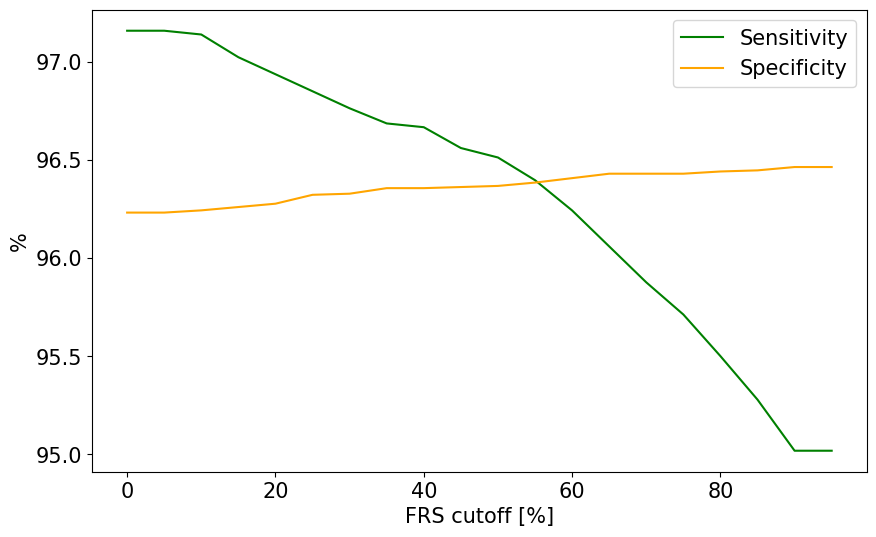

In [14]:
#plot the sensitivity for different FRS cutoffs
sensitivity = []
specificity = []
PPV = []
NPV = []
FRS = []

for i in range(0, 100, 5):
    cutoff = i/100
    df = mutations_agg_phen.copy()

    # assign RESISTANT_MUTATION column to True if FRS is >= cutoff while R_MINOR_ALLELE is True or if R_MAJOR_ALLELE is True
    df['RESISTANT_MUTATION'] = ((df['FRS'] >= cutoff) & (df['R_MINOR_ALLELE'] == True)) | (df['R_MAJOR_ALLELE'] == True)

    # df = df[(df.FRS.isna())|(df.FRS>=cutoff)]

    # calculate_statistics(df)
    sensitivity.append(df[(df['PHENOTYPE'] == True) & (df['RESISTANT_MUTATION'] == True)].shape[0] / df[df['PHENOTYPE'] == True].shape[0])
    specificity.append(df[(df['PHENOTYPE'] == False) & (df['RESISTANT_MUTATION'] == False)].shape[0] / df[df['PHENOTYPE'] == False].shape[0])
    # PPV.append(df[(df['RESISTANT_MUTATION'] == True) & (df['PHENOTYPE'] == True)].shape[0] / df[df['RESISTANT_MUTATION'] == True].shape[0])
    # NPV.append(df[(df['RESISTANT_MUTATION'] == False) & (df['PHENOTYPE'] == False)].shape[0] / df[df['RESISTANT_MUTATION'] == False].shape[0])
    FRS.append(cutoff)


fig, ax1 = plt.subplots(figsize=(10, 6))

#plot sensitivity and specificity using one y axis
plt.plot(FRS, sensitivity, label = 'Sensitivity', color = 'green')
plt.plot(FRS, specificity, label = 'Specificity', color = 'orange') 
plt.legend(fontsize=15)
plt.xlabel('FRS cutoff [%]', fontsize=15)
plt.ylabel('%', fontsize=15)
# plt.title('Sensitivity and Specificity for different FRS cutoffs')

#increase tick label sizes
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Set axes to display values as percentages without the percent sign
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1f}'.format(y * 100)))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x * 100)))

# #save figure in high resolution
plt.savefig('figures/sensitivity_specificity_FRS_cutoff.png', dpi=300)

plt.show()

Check how much presence of CMs can improve predictions (with and without considering minor alleles)

In [15]:
#calculate statistics for CMs indicating resistance, excluding minor alleles
CM_mutations = mutations_agg_phen.copy()
CM_mutations['RESISTANT_MUTATION'] = (CM_mutations['COMPENSATORY_MUTATION'] == True) | (CM_mutations['R_MAJOR_ALLELE'] == True)
print(CM_mutations.RESISTANT_MUTATION.value_counts())
sen_CM_maj, spe_CM_maj, ppv_CM_maj, npv_CM_maj = calculate_statistics(CM_mutations)
sen_CM_maj, spe_CM_maj, ppv_CM_maj, npv_CM_maj

RESISTANT_MUTATION
False    17540
True     10512
Name: count, dtype: int64


(0.9523075440793911,
 0.9644655689469813,
 0.9402587519025876,
 0.9717787913340935)

In [16]:
#calculate statistics for FRS cutoff >=0.9 (major allele definition) without considering CMs
major_mutations = mutations_agg_phen.copy()
major_mutations['RESISTANT_MUTATION'] = major_mutations['R_MAJOR_ALLELE']
print(major_mutations.RESISTANT_MUTATION.value_counts())
sen_maj, spe_maj, ppv_maj, npv_maj = calculate_statistics(major_mutations)
sen_maj, spe_maj, ppv_maj, npv_maj

RESISTANT_MUTATION
False    17566
True     10486
Name: count, dtype: int64


(0.9501878793718085, 0.964691902902733, 0.940492084684341, 0.9705681430035296)

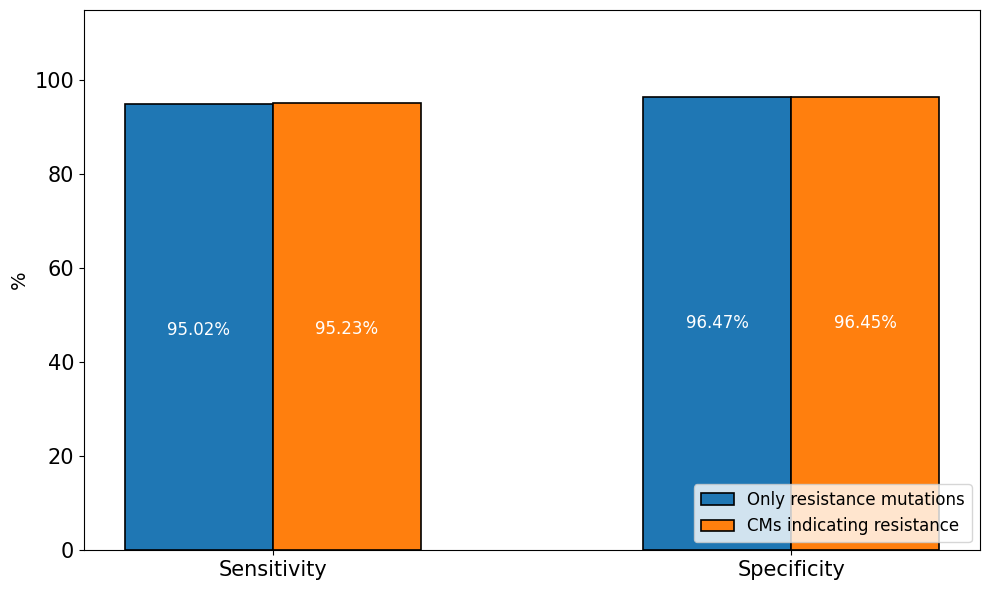

In [17]:
stats = create_stats_df(sen_maj, sen_CM_maj, spe_maj, spe_CM_maj)
plot_stats_histogram(stats, significant = False, save_figure=True, save_name = 'sensitivity_specificity_histogram_CM', legend_label_1='Only resistance mutations', legen_label_2='CMs indicating resistance')

In [18]:
#perform a z test to test for significant difference between the sensitivities and specificities
from statsmodels.stats.proportion import proportions_ztest

# Sensitivity
count = np.array([major_mutations[(major_mutations['PHENOTYPE'] == True) & (major_mutations['RESISTANT_MUTATION'] == True)].shape[0], CM_mutations[(CM_mutations['PHENOTYPE'] == True) & (CM_mutations['RESISTANT_MUTATION'] == True)].shape[0]])
nobs = np.array([major_mutations[major_mutations['PHENOTYPE'] == True].shape[0], CM_mutations[CM_mutations['PHENOTYPE'] == True].shape[0]])
z, p = proportions_ztest(count, nobs)
print(count, nobs, z, p)

# Specificity
count = np.array([major_mutations[(major_mutations['PHENOTYPE'] == False) & (major_mutations['RESISTANT_MUTATION'] == False)].shape[0], CM_mutations[(CM_mutations['PHENOTYPE'] == False) & (CM_mutations['RESISTANT_MUTATION'] == False)].shape[0]])
nobs = np.array([major_mutations[major_mutations['PHENOTYPE'] == False].shape[0], CM_mutations[CM_mutations['PHENOTYPE'] == False].shape[0]])
z, p = proportions_ztest(count, nobs)
print(count, nobs, z, p)


[9862 9884] [10379 10379] -0.709064286924491 0.4782845838113805
[17049 17045] [17673 17673] 0.1151036207073956 0.9083629900717725


In [19]:
#calculate statistics for CMs indicating resistance, including minor alleles
CM_mutations_minor = mutations_agg_phen.copy()
CM_mutations_minor['RESISTANT_MUTATION'] = (CM_mutations_minor['COMPENSATORY_MUTATION'] == True) | (CM_mutations_minor['RESISTANT_MUTATION'] == True)
print(CM_mutations_minor.RESISTANT_MUTATION.value_counts())
sen_CM_all, spe_CM_all, ppv_CM_all, npv_CM_all = calculate_statistics(CM_mutations_minor)
sen_CM_all, spe_CM_all, ppv_CM_all, npv_CM_all

RESISTANT_MUTATION
False    17288
True     10764
Name: count, dtype: int64


(0.9728297523846228, 0.9622588128784021, 0.938034188034188, 0.9836881073577047)

In [20]:
#calculate statistics for no FRS cutoff, without considering CMs
print(mutations_agg_phen.RESISTANT_MUTATION.value_counts())
sen_all, spe_all, ppv_all, npv_all = calculate_statistics(mutations_agg_phen)
sen_all, spe_all, ppv_all, npv_all

RESISTANT_MUTATION
False    17302
True     10750
Name: count, dtype: int64


(0.971577223239233, 0.96231539636734, 0.938046511627907, 0.9829499479828921)

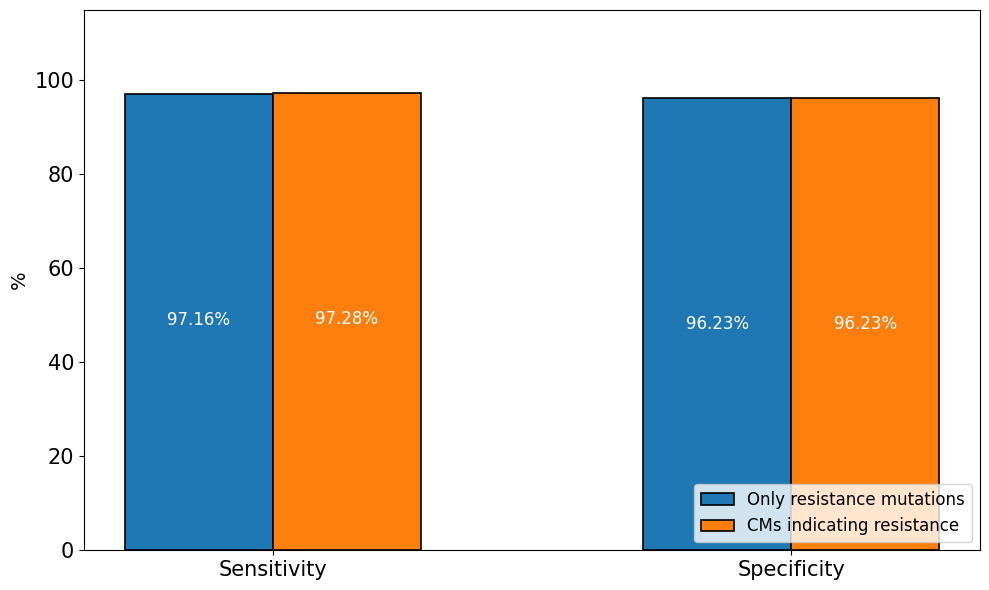

In [21]:
stats = create_stats_df(sen_all, sen_CM_all, spe_all, spe_CM_all)
plot_stats_histogram(stats, significant = False, save_figure=True, save_name = 'sensitivity_specificity_histogram_CM_minor', legend_label_1='Only resistance mutations', legen_label_2='CMs indicating resistance')

In [22]:
#perform a z test to test for significant difference between the sensitivities and specificities
from statsmodels.stats.proportion import proportions_ztest

# Sensitivity
count = np.array([mutations_agg_phen[(mutations_agg_phen['PHENOTYPE'] == True) & (mutations_agg_phen['RESISTANT_MUTATION'] == True)].shape[0], CM_mutations_minor[(CM_mutations_minor['PHENOTYPE'] == True) & (CM_mutations_minor['RESISTANT_MUTATION'] == True)].shape[0]])
nobs = np.array([mutations_agg_phen[mutations_agg_phen['PHENOTYPE'] == True].shape[0], CM_mutations_minor[CM_mutations_minor['PHENOTYPE'] == True].shape[0]])
z, p = proportions_ztest(count, nobs)
print(count, nobs, z, p)

# Specificity
count = np.array([mutations_agg_phen[(mutations_agg_phen['PHENOTYPE'] == False) & (mutations_agg_phen['RESISTANT_MUTATION'] == False)].shape[0], CM_mutations_minor[(CM_mutations_minor['PHENOTYPE'] == False) & (CM_mutations_minor['RESISTANT_MUTATION'] == False)].shape[0]])
nobs = np.array([mutations_agg_phen[mutations_agg_phen['PHENOTYPE'] == False].shape[0], CM_mutations_minor[CM_mutations_minor['PHENOTYPE'] == False].shape[0]])
z, p = proportions_ztest(count, nobs)
print(count, nobs, z, p)

[10084 10097] [10379 10379] -0.5488793074361511 0.5830882796172004
[17007 17006] [17673 17673] 0.027921104387451576 0.9777250761371025


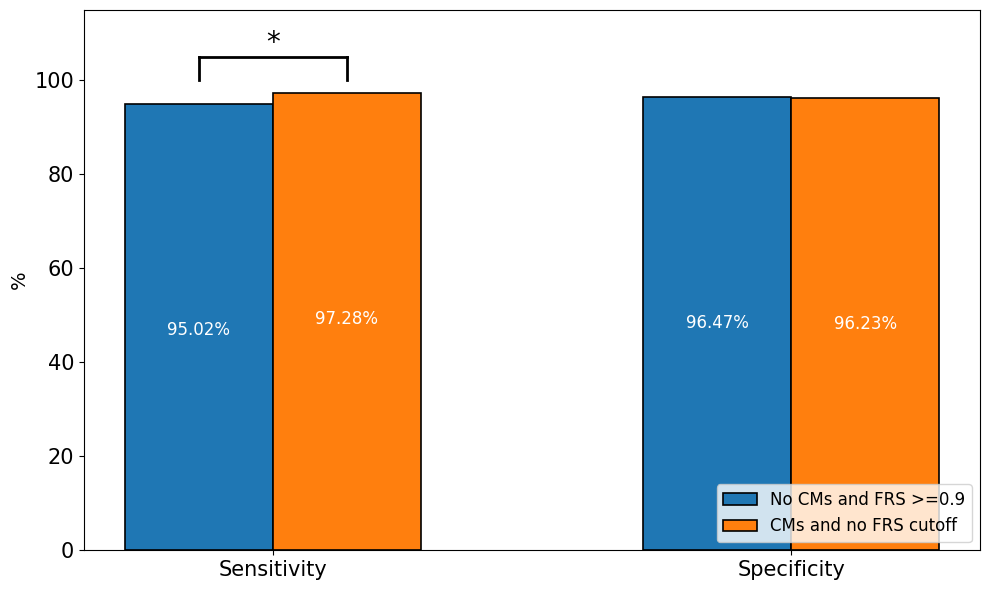

In [23]:
#Lastly, compare the sensitivity and specificity for FRS cutoff >=0.9 (major allele definition) without considering CMs with the sensitivity and specificity for CMs and minor alleles indicating resistance
stats = create_stats_df(sen_maj, sen_CM_all, spe_maj, spe_CM_all)
plot_stats_histogram(stats, significant = True, save_figure=True, save_name = 'sensitivity_specificity_histogram_all_vs_major', legend_label_1='No CMs and FRS >=0.9', legen_label_2='CMs and no FRS cutoff')

Check how CM presence differs in major and minor allele populations

In [24]:
# aggregate mutations_phenotype by UNIQUEID and keep columns of interest: double-check if definiion of FRS is correct
def aggregate_minor_major_allele(group):
    # Check if any row has both IS_MINOR_ALLELE == True and RESISTANT_MUTATION == True
    minor_allele_flag = any((group['IS_MINOR_ALLELE'] == True) & (group['RESISTANT_MUTATION'] == True))
    major_allele_flag = any((group['IS_MINOR_ALLELE'] == False) & (group['RESISTANT_MUTATION'] == True))

    # Get the rows where there is a resistant minor allele
    resistant_minor_allele_rows = group[(group['IS_MINOR_ALLELE'] == True) & (group['RESISTANT_MUTATION'] == True)]
    
    if not resistant_minor_allele_rows.empty:
        # If there are resistant minor alleles, get the maximum FRS value for those rows
        frs_value = resistant_minor_allele_rows['FRS'].max()
    else:
        # Otherwise, use the maximum FRS value from the entire group
        frs_value = group['FRS'].max()
    
    return pd.Series({
        'RESISTANT_MUTATION': group['RESISTANT_MUTATION'].max(),
        'COMPENSATORY_MUTATION': group['COMPENSATORY_MUTATION'].max(),
        'R_MINOR_ALLELE': minor_allele_flag,
        'R_MAJOR_ALLELE': major_allele_flag,
        'FRS': frs_value,  # Use the maximum FRS for resistant minor alleles, if present
    })

# Apply the custom aggregation function
mutations_agg = mutations.groupby('UNIQUEID').apply(aggregate_minor_major_allele).reset_index()

/var/folders/_3/8y_dwngx2614_y_52fzh1c4w0000gn/T/ipykernel_36975/2026146715.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mutations_agg = mutations.groupby('UNIQUEID').apply(aggregate_minor_major_allele).reset_index()


In [25]:
mutations_agg
#save mutations_agg table
mutations_agg.to_csv('data/mutations_agg-UNIQUEID.csv', index = False)

In [26]:
#check overlap
overlap = mutations_agg[(mutations_agg['R_MAJOR_ALLELE'] == True) & (mutations_agg['R_MINOR_ALLELE'] == True)].UNIQUEID.to_list()
len(overlap)

30

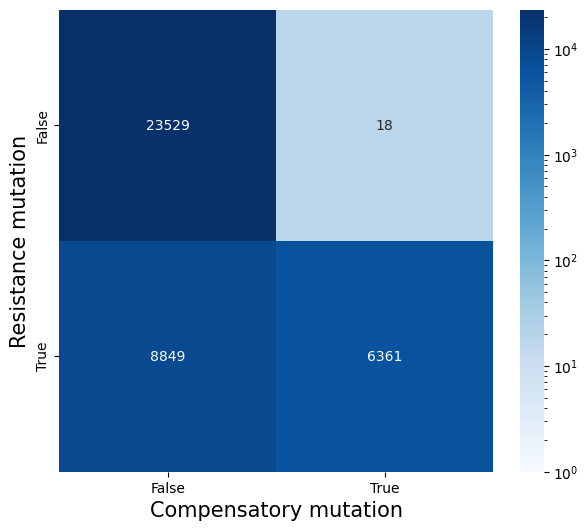

In [27]:
#make contingency matrix for samples based on resistance and compensatory mutations, exluding the overlap
from matplotlib.colors import LogNorm
def contingency_heatmap(df, overlap, save_name='contingency_heatmap.png'):
    contingency = pd.crosstab(df[~df['UNIQUEID'].isin(overlap)]['RESISTANT_MUTATION'], df[~df['UNIQUEID'].isin(overlap)]['COMPENSATORY_MUTATION'])
    contingency

    #show contingency matrix as heatmap in green colour, wihtout rounded values
    plt.figure(figsize=(7, 6))
    sns.heatmap(contingency, annot=True, fmt='d', cmap='Blues', 
                norm=LogNorm(vmin=1, vmax=contingency.max().max()), cbar=True)
    # plt.title('Contingency matrix for resistance and compensatory mutations')
    plt.xlabel('Compensatory mutation', fontsize=15)
    plt.ylabel('Resistance mutation', fontsize=15)

    #save figure in high resolution
    plt.savefig(f'figures/{save_name}', dpi=300)

    plt.show()

contingency_heatmap(mutations_agg, overlap, save_name='contingency_heatmap.png')

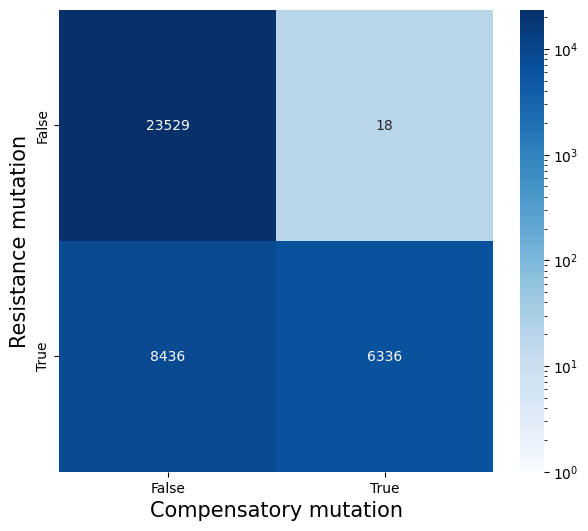

In [28]:
#exclude all samples with a minor allele from the analysis
mutations_agg_major = mutations_agg[~mutations_agg['R_MINOR_ALLELE']]
contingency_heatmap(mutations_agg_major, overlap, save_name='contingency_heatmap_major.png')


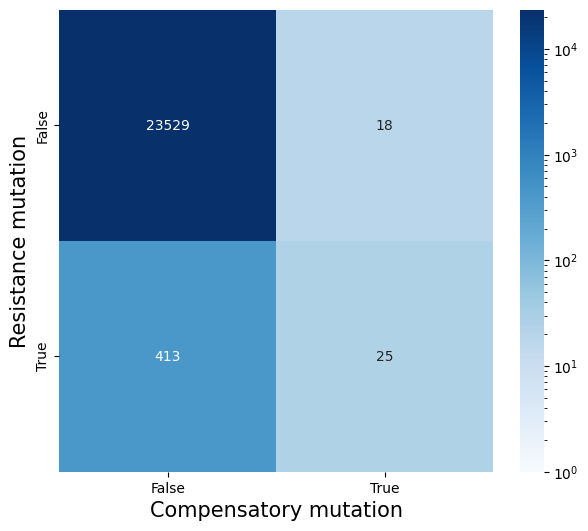

In [29]:
#exclude all samples with a resistant major allele from the analysis
mutations_agg_minor = mutations_agg[~mutations_agg['R_MAJOR_ALLELE']]
contingency_heatmap(mutations_agg_minor, overlap, save_name='contingency_heatmap_minor.png')

In [30]:
contingency_major = pd.crosstab(mutations_agg_major[~mutations_agg_major['UNIQUEID'].isin(overlap)]['RESISTANT_MUTATION'], mutations_agg_major[~mutations_agg_major['UNIQUEID'].isin(overlap)]['COMPENSATORY_MUTATION'])
contingency_major.iloc[1,1]/contingency_major.sum(axis=1)[1]

contingency_minor = pd.crosstab(mutations_agg_minor[~mutations_agg_minor['UNIQUEID'].isin(overlap)]['RESISTANT_MUTATION'], mutations_agg_minor[~mutations_agg_minor['UNIQUEID'].isin(overlap)]['COMPENSATORY_MUTATION'])
contingency_minor.iloc[1,1]/contingency_minor.sum(axis=1)[1]


/var/folders/_3/8y_dwngx2614_y_52fzh1c4w0000gn/T/ipykernel_36975/244543749.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  contingency_major.iloc[1,1]/contingency_major.sum(axis=1)[1]
/var/folders/_3/8y_dwngx2614_y_52fzh1c4w0000gn/T/ipykernel_36975/244543749.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  contingency_minor.iloc[1,1]/contingency_minor.sum(axis=1)[1]


np.float64(0.05707762557077625)

/var/folders/_3/8y_dwngx2614_y_52fzh1c4w0000gn/T/ipykernel_36975/2718738671.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  major_percentage = contingency_major.iloc[1,1]/contingency_major.sum(axis=1)[1]
/var/folders/_3/8y_dwngx2614_y_52fzh1c4w0000gn/T/ipykernel_36975/2718738671.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  minor_percentage = contingency_minor.iloc[1,1]/contingency_minor.sum(axis=1)[1]


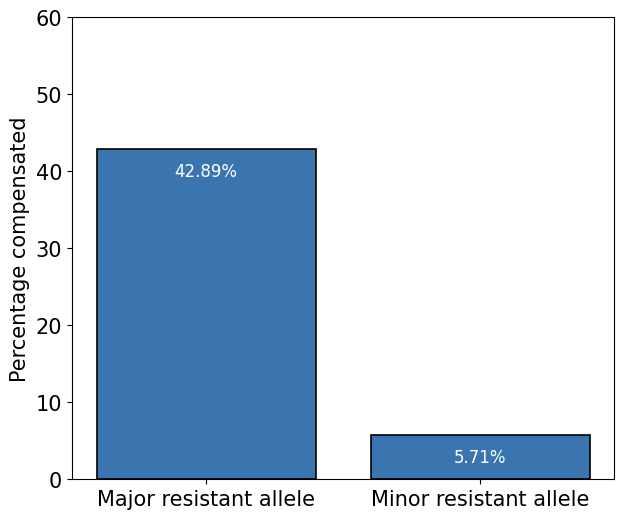

In [31]:
#make nice percentage plot of percentage of compensation in major vs minor resistant populations
#also plot the data as a bar plot of the lower row of the contingency matrix
def compensation_barplot(major_df, minor_df, save_name='contingency_barplot.png'):
    contingency_major = pd.crosstab(major_df[~major_df['UNIQUEID'].isin(overlap)]['RESISTANT_MUTATION'], major_df[~major_df['UNIQUEID'].isin(overlap)]['COMPENSATORY_MUTATION'])
    major_percentage = contingency_major.iloc[1,1]/contingency_major.sum(axis=1)[1]

    contingency_minor = pd.crosstab(minor_df[~minor_df['UNIQUEID'].isin(overlap)]['RESISTANT_MUTATION'], minor_df[~minor_df['UNIQUEID'].isin(overlap)]['COMPENSATORY_MUTATION'])
    minor_percentage = contingency_minor.iloc[1,1]/contingency_minor.sum(axis=1)[1]

    #plot the two percentages as a nice bar plot
    plt.figure(figsize=(7, 6))
    plt.bar(['Major resistant allele', 'Minor resistant allele'], [major_percentage, minor_percentage], color=['#3B75AF', '#3B75AF'], edgecolor='black', linewidth=1.2)
    plt.ylabel('Percentage compensated', fontsize=15)
    plt.ylim(0, 0.6)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    #display percentages inside bars
    for i in range(2):
        plt.text(i, [major_percentage, minor_percentage][i] - 0.04, f'{[major_percentage, minor_percentage][i]:.2%}', ha='center', va='bottom', fontsize=12, color='white')

    # Set axes to display values as percentages without the percent sign
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}'.format(y * 100)))

    #save figure in high resolution
    plt.savefig(f'figures/{save_name}', dpi=300)

    plt.show()

compensation_barplot(mutations_agg_major, mutations_agg_minor, save_name='contingency_barplot.png')

Check if the CMs found in resistant minor populations have an FRS similar or lower than the resistance mutation FRS

In [75]:
#Get the Uniqueids of samples with a resistant minor allele and a compensatory mutation and no resistant major mutations 
# - should be the lower right corner of the contingency table
res_minor_CM_uniqueids = mutations_agg[(~mutations_agg.R_MAJOR_ALLELE == True) 
                                       & (mutations_agg.COMPENSATORY_MUTATION == True) & (mutations_agg.R_MINOR_ALLELE == True)].UNIQUEID
len(res_minor_CM_uniqueids)

25

In [76]:
#get the Uniqueids of samples with a resistant minor allele and a MINOR compensatory mutation and no resistant major mutations
res_minor_CM_minor_uniqueids = mutations[mutations.UNIQUEID.isin(res_minor_CM_uniqueids) & (mutations.COMPENSATORY_MUTATION == True) & (mutations.IS_MINOR_ALLELE == True)].UNIQUEID
len(res_minor_CM_minor_uniqueids)

13

In [77]:
#compare to number of minor compensatory mutations in whole dataset
mutations[(mutations.COMPENSATORY_MUTATION == True)].IS_MINOR_ALLELE.value_counts()

IS_MINOR_ALLELE
False    6347
True       44
Name: count, dtype: int64

In [78]:
resistance = mutations[(mutations.RESISTANT_MUTATION == True) & (mutations.UNIQUEID.isin(res_minor_CM_minor_uniqueids))]
resistance

,UNIQUEID,GENE,MUTATION,REF,ALT,NUCLEOTIDE_NUMBER,NUCLEOTIDE_INDEX,GENE_POSITION,CODES_PROTEIN,INDEL_LENGTH,INDEL_NUCLEOTIDES,AMINO_ACID_NUMBER,AMINO_ACID_SEQUENCE,NUMBER_NUCLEOTIDE_CHANGES,IS_MINOR_ALLELE,MINOR_MUTATION,FRS,GENE_MUTATION,RESISTANT_MUTATION,COMPENSATORY_MUTATION
20367,site.04.subj.00574.lab.706414.iso.1,rpoB,S450Z,tcg,zzz,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,True,S450L,0.441,rpoB_S450L,True,False
34371,site.04.subj.00622.lab.706166.iso.1,rpoB,D435Z,gac,zzz,NaN,NaN,435.0,True,NaN,NaN,435.0,Y,1.0,True,D435Y,0.758,rpoB_D435Y,True,False
34372,site.04.subj.00622.lab.706166.iso.1,rpoB,H445Z,cac,zzz,NaN,NaN,445.0,True,NaN,NaN,445.0,D,1.0,True,H445D,0.307,rpoB_H445D,True,False
50814,site.03.subj.T6596.lab.IML-00105.iso.1,rpoB,S450Z,tcg,zzz,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,True,S450L,0.198,rpoB_S450L,True,False
52171,site.03.subj.UZB16048.lab.UZB16048.iso.1,rpoB,S450Z,tcg,zzz,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,True,S450L,0.661,rpoB_S450L,True,False
59471,site.03.subj.UZB12040.lab.UZB12040.iso.1,rpoB,S450Z,tcg,zzz,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,True,S450L,0.318,rpoB_S450L,True,False
61659,site.03.subj.UZB9727.lab.UZB9727.iso.1,rpoB,S450Z,tcg,zzz,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,True,S450L,0.171,rpoB_S450L,True,False
62550,site.03.subj.UZB9723.lab.UZB9723.iso.1,rpoB,S450Z,tcg,zzz,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,True,S450L,0.258,rpoB_S450L,True,False
63973,site.03.subj.11409-95_LIB8605.lab.11409-95_LIB...,rpoB,1309_minorindel,NaN,NaN,1309.0,761115.0,1309.0,True,-3.0,aac,NaN,NaN,0.0,True,1309_del_aac,0.140,rpoB_1309_del_aac,True,False
63976,site.03.subj.11409-95_LIB8605.lab.11409-95_LIB...,rpoB,S450Z,tcg,zzz,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,True,S450L,0.837,rpoB_S450L,True,False


In [79]:
compensatory = mutations[mutations.UNIQUEID.isin(res_minor_CM_minor_uniqueids) & (mutations.COMPENSATORY_MUTATION == True)]
compensatory

,UNIQUEID,GENE,MUTATION,REF,ALT,NUCLEOTIDE_NUMBER,NUCLEOTIDE_INDEX,GENE_POSITION,CODES_PROTEIN,INDEL_LENGTH,INDEL_NUCLEOTIDES,AMINO_ACID_NUMBER,AMINO_ACID_SEQUENCE,NUMBER_NUCLEOTIDE_CHANGES,IS_MINOR_ALLELE,MINOR_MUTATION,FRS,GENE_MUTATION,RESISTANT_MUTATION,COMPENSATORY_MUTATION
20366,site.04.subj.00574.lab.706414.iso.1,rpoB,P45Z,ccg,zzz,NaN,NaN,45.0,True,NaN,NaN,45.0,S,1.0,True,P45S,0.397,rpoB_P45S,False,True
34373,site.04.subj.00622.lab.706166.iso.1,rpoB,I491Z,atc,zzz,NaN,NaN,491.0,True,NaN,NaN,491.0,L,1.0,True,I491L,0.795,rpoB_I491L,False,True
50813,site.03.subj.T6596.lab.IML-00105.iso.1,rpoB,R827Z,cgc,zzz,NaN,NaN,827.0,True,NaN,NaN,827.0,L,1.0,True,R827L,0.138,rpoB_R827L,False,True
52169,site.03.subj.UZB16048.lab.UZB16048.iso.1,rpoB,K891Z,aag,zzz,NaN,NaN,891.0,True,NaN,NaN,891.0,E,1.0,True,K891E,0.523,rpoB_K891E,False,True
59470,site.03.subj.UZB12040.lab.UZB12040.iso.1,rpoB,L731Z,ctg,zzz,NaN,NaN,731.0,True,NaN,NaN,731.0,P,1.0,True,L731P,0.370,rpoB_L731P,False,True
61658,site.03.subj.UZB9727.lab.UZB9727.iso.1,rpoB,L731Z,ctg,zzz,NaN,NaN,731.0,True,NaN,NaN,731.0,P,1.0,True,L731P,0.161,rpoB_L731P,False,True
62549,site.03.subj.UZB9723.lab.UZB9723.iso.1,rpoB,L731Z,ctg,zzz,NaN,NaN,731.0,True,NaN,NaN,731.0,P,1.0,True,L731P,0.167,rpoB_L731P,False,True
63975,site.03.subj.11409-95_LIB8605.lab.11409-95_LIB...,rpoB,P45Z,ccg,zzz,NaN,NaN,45.0,True,NaN,NaN,45.0,S,1.0,True,P45S,0.374,rpoB_P45S,False,True
64747,site.03.subj.T8704.lab.IML00166.iso.1,rpoB,I488Z,atc,zzz,NaN,NaN,488.0,True,NaN,NaN,488.0,V,1.0,True,I488V,0.200,rpoB_I488V,False,True
84577,site.05.subj.LR-2591.lab.FN-01139-18.iso.1,rpoB,Q409Z,cag,zzz,NaN,NaN,409.0,True,NaN,NaN,409.0,R,1.0,True,Q409R,0.142,rpoB_Q409R,False,True


In [80]:
#join dfs resistance and compensation based on UNIQUEID
df_joined = pd.merge(resistance[['UNIQUEID','MINOR_MUTATION','FRS']], compensatory[['UNIQUEID','MINOR_MUTATION','FRS']], on = 'UNIQUEID', how = 'inner')
df_joined.rename(columns = {'FRS_x':'FRS_res','FRS_y':'FRS_CM','MINOR_MUTATION_x':'MINOR_MUTATION_res','MINOR_MUTATION_y':'MINOR_MUTATION_CM'}, inplace = True)
df_joined


,UNIQUEID,MINOR_MUTATION_res,FRS_res,MINOR_MUTATION_CM,FRS_CM
0,site.04.subj.00574.lab.706414.iso.1,S450L,0.441,P45S,0.397
1,site.04.subj.00622.lab.706166.iso.1,D435Y,0.758,I491L,0.795
2,site.04.subj.00622.lab.706166.iso.1,H445D,0.307,I491L,0.795
3,site.03.subj.T6596.lab.IML-00105.iso.1,S450L,0.198,R827L,0.138
4,site.03.subj.UZB16048.lab.UZB16048.iso.1,S450L,0.661,K891E,0.523
5,site.03.subj.UZB12040.lab.UZB12040.iso.1,S450L,0.318,L731P,0.370
6,site.03.subj.UZB9727.lab.UZB9727.iso.1,S450L,0.171,L731P,0.161
7,site.03.subj.UZB9723.lab.UZB9723.iso.1,S450L,0.258,L731P,0.167
8,site.03.subj.11409-95_LIB8605.lab.11409-95_LIB...,1309_del_aac,0.140,P45S,0.374
9,site.03.subj.11409-95_LIB8605.lab.11409-95_LIB...,S450L,0.837,P45S,0.374


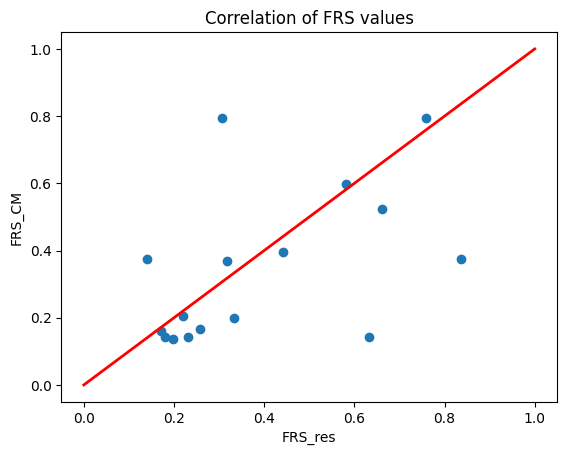

In [81]:
#compare the FRX_x and FRS_y columns to see if the FRS values are roughly the same
df_joined['FRS_res'] = df_joined['FRS_res'].astype(float)
df_joined['FRS_CM'] = df_joined['FRS_CM'].astype(float)

df_joined['FRS_res'].corr(df_joined['FRS_CM'])

#plot the FRS values for the samples with a minor allele and a compensatory mutation
plt.scatter(df_joined['FRS_res'], df_joined['FRS_CM']) 
#add a line through (1,1) to (0,0) to indicate a perfect correlation
plt.plot([0, 1], [0, 1], color='red', lw=2)
plt.xlabel('FRS_res')
plt.ylabel('FRS_CM')
plt.title('Correlation of FRS values')

plt.show()

In [82]:
#calculate correlation score
from scipy.stats import pearsonr
correlation, p_value = pearsonr(df_joined['FRS_res'], df_joined['FRS_CM'])
correlation, p_value

(np.float64(0.5025973171709659), np.float64(0.04723866503572301))

Check how Pearson correlation changes if we remove minor resistant mutations from the same sample and pnly keep the higher FRS

In [83]:
#Check how Pearson correlation changes if we remove minor resistant mutations from the same sample and pnly keep the higher FRS value
df_joined_max = df_joined.groupby('UNIQUEID').agg({'FRS_res':'max', 'FRS_CM':'max'}).reset_index()
correlation_max, p_value_max = pearsonr(df_joined_max['FRS_res'], df_joined_max['FRS_CM'])
correlation_max, p_value_max


(np.float64(0.696315663222213), np.float64(0.008193339610125321))

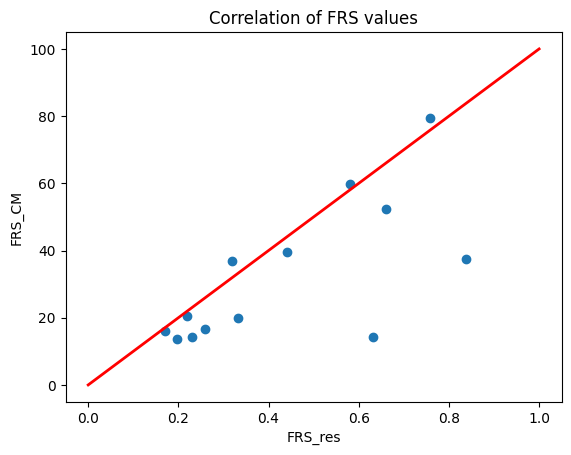

In [85]:
#plot correlation of FRS values for samples with a minor allele and a compensatory mutation, keeping only the higher FRS value
plt.scatter(df_joined_max['FRS_res'], df_joined_max['FRS_CM'])
plt.plot([0, 1], [0, 1], color='red', lw=2)
plt.xlabel('FRS_res')
plt.ylabel('FRS_CM')
plt.title('Correlation of FRS values')

# Set axes to display values as percentages without the percent sign
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}'.format(y * 100)))

#save figure in high resolution
plt.savefig('figures/FRS_correlation_CM.png', dpi=300)

plt.show()


In [86]:
#check how often FRS_x is higher than FRS_y in the joined max table
df_joined_max['FRS_x_higher'] = df_joined_max['FRS_res'] > df_joined_max['FRS_CM']
df_joined_max['FRS_x_higher'].value_counts()


FRS_x_higher
True     10
False     3
Name: count, dtype: int64

Check if the samples with mixed populations have evolved resistance or acquired another infection - look how many other minor alleles we see in these samples and if the FRS also correlates

In [87]:
res_minor_uniqueids = mutations_agg[mutations_agg['R_MINOR_ALLELE']].UNIQUEID

In [88]:
res_minor_uniqueids

136              site.00.subj.1190242.lab.H124040080.iso.1
247              site.00.subj.1473471.lab.H140800280.iso.1
574                    site.00.subj.ES_FE21.lab.FE21.iso.1
575                    site.00.subj.ES_FE23.lab.FE23.iso.1
681      site.00.subj.NETHERLANDS_NLA000300848.lab.NLA0...
                               ...                        
38556                     site.28.subj.861.lab.R9161.iso.1
38668              site.35.subj.201.lab.IMRL_NGS_234.iso.1
38685              site.35.subj.224.lab.IMRL_NGS_260.iso.1
38714              site.35.subj.267.lab.IMRL_NGS_315.iso.1
38775                       site.35.subj.88.lab.IE12.iso.1
Name: UNIQUEID, Length: 468, dtype: object

In [89]:
mutations[(mutations.UNIQUEID.isin(res_minor_uniqueids)) & (mutations.IS_MINOR_ALLELE == True) & (mutations.RESISTANT_MUTATION == False)]
#plot the FRS of the highest abundant resistant minor allele against the FRS of the other minor alleles occuring in that UNQIUEID


,UNIQUEID,GENE,MUTATION,REF,ALT,NUCLEOTIDE_NUMBER,NUCLEOTIDE_INDEX,GENE_POSITION,CODES_PROTEIN,INDEL_LENGTH,INDEL_NUCLEOTIDES,AMINO_ACID_NUMBER,AMINO_ACID_SEQUENCE,NUMBER_NUCLEOTIDE_CHANGES,IS_MINOR_ALLELE,MINOR_MUTATION,FRS,GENE_MUTATION,RESISTANT_MUTATION,COMPENSATORY_MUTATION
355,site.01.subj.DR0182.lab.DR0182.iso.1,rpoB,A1075Z,gct,zzz,NaN,NaN,1075.0,True,NaN,NaN,1075.0,A,1.0,True,A1075A,0.165,rpoB_A1075A,False,False
486,site.16.subj.001.lab.10398.iso.1,rpoB,A1075Z,gct,zzz,NaN,NaN,1075.0,True,NaN,NaN,1075.0,A,1.0,True,A1075A,0.116,rpoB_A1075A,False,False
488,site.16.subj.001.lab.10398.iso.1,rpoB,I1106Z,atc,zzz,NaN,NaN,1106.0,True,NaN,NaN,1106.0,T,1.0,True,I1106T,0.888,rpoB_I1106T,False,False
494,site.16.subj.001.lab.15323.iso.1,rpoB,-35_minorindel,NaN,NaN,-35.0,759772.0,-35.0,False,-1.0,c,NaN,NaN,0.0,True,-35_del_c,0.565,rpoB_-35_del_c,False,False
495,site.16.subj.001.lab.15323.iso.1,rpoB,-43_minorindel,NaN,NaN,-43.0,759764.0,-43.0,False,-3.0,taa,NaN,NaN,0.0,True,-43_del_taa,0.573,rpoB_-43_del_taa,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176432,site.07.subj.B2BA5DAF-6370-4E99-B3E9-782C61686...,rpoB,V994Z,gtg,zzz,NaN,NaN,994.0,True,NaN,NaN,994.0,V,1.0,True,V994V,0.250,rpoB_V994V,False,False
176433,site.07.subj.B2BA5DAF-6370-4E99-B3E9-782C61686...,rpoB,V996Z,gtc,zzz,NaN,NaN,996.0,True,NaN,NaN,996.0,V,1.0,True,V996V,0.240,rpoB_V996V,False,False
176434,site.07.subj.B2BA5DAF-6370-4E99-B3E9-782C61686...,rpoB,Y308Z,tat,zzz,NaN,NaN,308.0,True,NaN,NaN,308.0,Y,1.0,True,Y308Y,0.283,rpoB_Y308Y,False,False
176435,site.07.subj.B2BA5DAF-6370-4E99-B3E9-782C61686...,rpoB,Y338Z,tat,zzz,NaN,NaN,338.0,True,NaN,NaN,338.0,Y,1.0,True,Y338Y,0.271,rpoB_Y338Y,False,False


In [90]:
res_minor = mutations[mutations.UNIQUEID.isin(res_minor_uniqueids) & (mutations.RESISTANT_MUTATION == True) & (mutations.IS_MINOR_ALLELE == True)]
other_minor = mutations[mutations.UNIQUEID.isin(res_minor_uniqueids) & (mutations.RESISTANT_MUTATION == False) & (mutations.IS_MINOR_ALLELE == True)]



In [91]:
len(res_minor), len(other_minor)

(634, 6387)

In [92]:
df_joined = pd.merge(res_minor[['UNIQUEID','MINOR_MUTATION','FRS']], other_minor[['UNIQUEID','MINOR_MUTATION','FRS']], on = 'UNIQUEID', how = 'inner')
df_joined.rename(columns = {'FRS_x':'FRS_res','FRS_y':'FRS_other','MINOR_MUTATION_x':'MINOR_MUTATION_res','MINOR_MUTATION_other':'MINOR_MUTATION_CM'}, inplace = True)
df_joined

,UNIQUEID,MINOR_MUTATION_res,FRS_res,MINOR_MUTATION_y,FRS_other
0,site.01.subj.DR0182.lab.DR0182.iso.1,S450L,0.127,A1075A,0.165
1,site.16.subj.001.lab.10398.iso.1,D435G,0.819,A1075A,0.116
2,site.16.subj.001.lab.10398.iso.1,D435G,0.819,I1106T,0.888
3,site.16.subj.001.lab.10398.iso.1,L452P,0.828,A1075A,0.116
4,site.16.subj.001.lab.10398.iso.1,L452P,0.828,I1106T,0.888
...,...,...,...,...,...
8767,site.07.subj.B2BA5DAF-6370-4E99-B3E9-782C61686...,1284_del_c,0.364,V994V,0.250
8768,site.07.subj.B2BA5DAF-6370-4E99-B3E9-782C61686...,1284_del_c,0.364,V996V,0.240
8769,site.07.subj.B2BA5DAF-6370-4E99-B3E9-782C61686...,1284_del_c,0.364,Y308Y,0.283
8770,site.07.subj.B2BA5DAF-6370-4E99-B3E9-782C61686...,1284_del_c,0.364,Y338Y,0.271


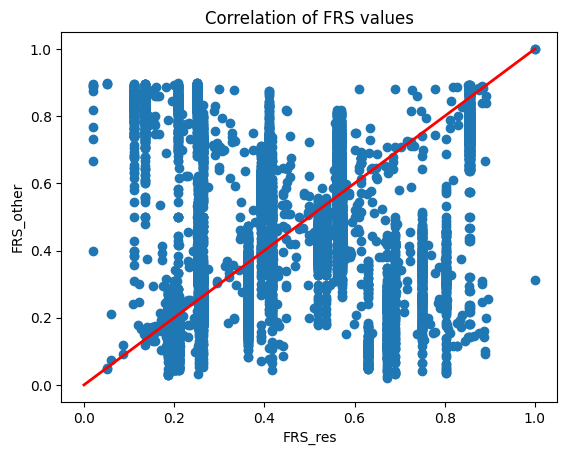

In [93]:
#compare the FRX_x and FRS_y columns to see if the FRS values are roughly the same
df_joined['FRS_res'] = df_joined['FRS_res'].astype(float)
df_joined['FRS_other'] = df_joined['FRS_other'].astype(float)

df_joined['FRS_res'].corr(df_joined['FRS_other'])

#plot the FRS values for the samples with a minor allele and a compensatory mutation
plt.scatter(df_joined['FRS_res'], df_joined['FRS_other']) 
#add a line through (1,1) to (0,0) to indicate a perfect correlation
plt.plot([0, 1], [0, 1], color='red', lw=2)
plt.xlabel('FRS_res')
plt.ylabel('FRS_other')
plt.title('Correlation of FRS values')

plt.show()

In [94]:
#Check how Pearson correlation changes if we remove minor resistant mutations from the same sample and only keep the higher FRS value
df_joined_max = df_joined.groupby('UNIQUEID').agg({'FRS_res':'max', 'FRS_other':'max'}).reset_index()
correlation_max, p_value_max = pearsonr(df_joined_max['FRS_res'], df_joined_max['FRS_other'])
correlation_max, p_value_max

(np.float64(0.045001903243355575), np.float64(0.49144626886008264))

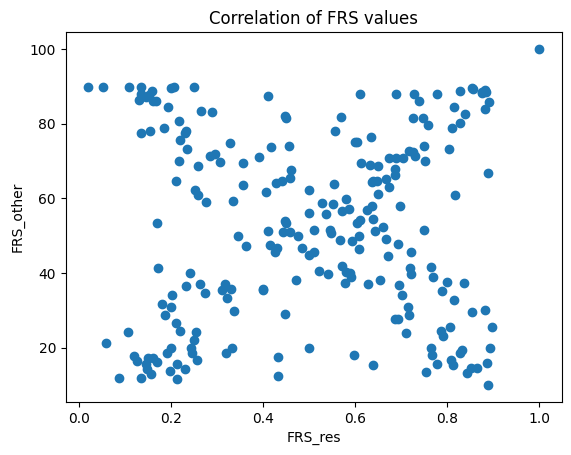

In [95]:
#plot correlation of FRS values for samples with a minor allele and a compensatory mutation, keeping only the higher FRS value
plt.scatter(df_joined_max['FRS_res'], df_joined_max['FRS_other'])
# plt.plot([0, 1], [0, 1], color='red', lw=2)
plt.xlabel('FRS_res')
plt.ylabel('FRS_other')
plt.title('Correlation of FRS values')

# Set axes to display values as percentages without the percent sign
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}'.format(y * 100)))

#save figure in high resolution
plt.savefig('figures/FRS_correlation_other.png', dpi=300)

plt.show()

In [96]:
df_joined_max

,UNIQUEID,FRS_res,FRS_other
0,site.00.subj.1190242.lab.H124040080.iso.1,0.087,0.118
1,site.00.subj.PERU_02-R0951.lab.02-R0951.iso.1,0.725,0.723
2,site.01.subj.DR0182.lab.DR0182.iso.1,0.127,0.165
3,site.02.subj.0188.lab.2013222133.iso.1,0.312,0.355
4,site.02.subj.0485.lab.235059-14.iso.1,0.829,0.801
...,...,...,...
231,site.28.subj.2054.lab.R26228.iso.1,0.753,0.700
232,site.28.subj.2133.lab.R28017.iso.1,0.135,0.774
233,site.28.subj.861.lab.R9161.iso.1,0.521,0.405
234,site.35.subj.224.lab.IMRL_NGS_260.iso.1,0.200,0.308


In [106]:
import plotly.express as px
from sklearn.decomposition import PCA

df = df_joined_max
X = df[['FRS_res', 'FRS_other']]
# df = px.data.iris()
# X = df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]

[52.25009516 47.74990484]


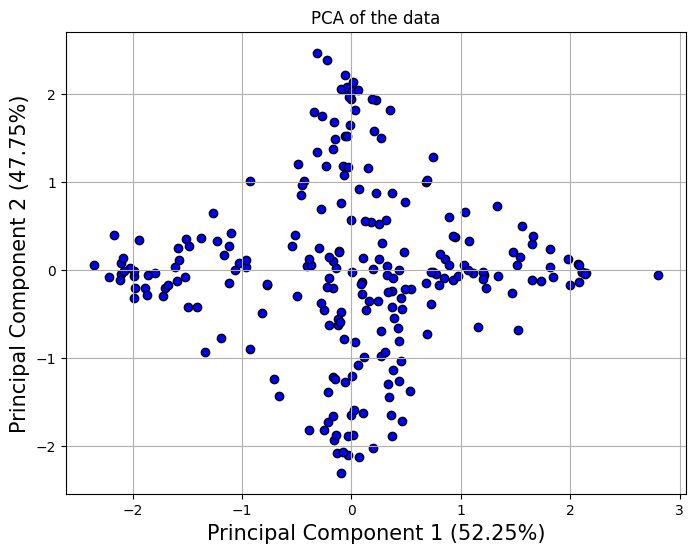

In [112]:
from sklearn.preprocessing import StandardScaler
# Standardize data
X_scaled = StandardScaler().fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
ex_var = pca.explained_variance_ratio_ * 100
print(ex_var)

# Plot PCA result
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue', edgecolor='k')
plt.xlabel('Principal Component 1 ({}%)'.format(round(ex_var[0], 2)), fontsize=15)
plt.ylabel('Principal Component 2 ({}%)'.format(round(ex_var[1], 2)), fontsize=15)
plt.title('PCA of the data')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Sample data
X = X
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Get the principal components
components = pca.components_

# Create a scatter plot of the PCA-transformed data
plt.scatter(X_pca[:, 0], X_pca[:, 1], label='Data points')

# Plot the original axes in PCA space (original feature space)
# Here we plot each feature's contribution as vectors
for i, (component, var) in enumerate(zip(components, pca.explained_variance_ratio_)):
    # Scale the vector by the explained variance (optional)
    vector = component * max(X_pca[:, 0]) * var
    plt.arrow(0, 0, vector[0], vector[1], color='r', width=0.01, head_width=0.05, label=f'Feature {i+1}')
    plt.text(vector[0] * 1.2, vector[1] * 1.2, f'Feature {i+1}', color='r', ha='center', va='center')

# Customize plot
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA with Original Feature Axes')
plt.legend()
plt.grid()

plt.show()